In [1]:
import scprep
import pandas as pd
import numpy as np
import scprep
import matplotlib.pyplot as plt
import umap
import tasklogger
import phenograph
import graphtools as gt
import louvain
import phate
import sklearn.manifold

/gpfs/ysm/project/dunn/nnp9/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
data = scprep.io.load_10X("/home/nnp9/project/podocoryna/results/cellranger/counts/podocoryna_carnea/outs/filtered_feature_bc_matrix")
# data.head()
data.shape #3,259 cells and 41,678 genes

(3259, 41678)

<AxesSubplot:title={'center':'Library Size of Filtered Cells'}, xlabel='Library size', ylabel='Number of cells'>

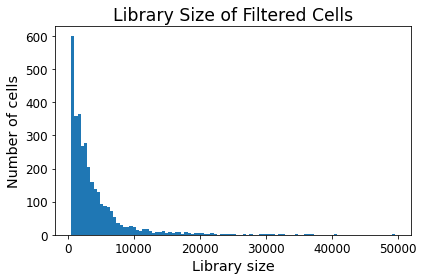

In [3]:
metadata = pd.DataFrame(index = data.index)
scprep.plot.plot_library_size(data,
                              log=False, title='Library Size of Filtered Cells')

<AxesSubplot:title={'center':'Mitochondrial expression before filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

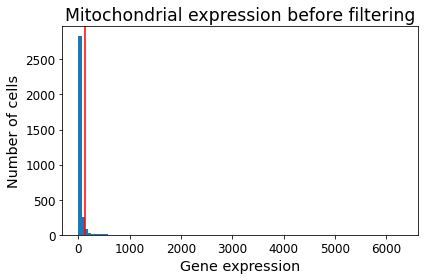

In [4]:
# Plot all mitochondrial genes. There is only 1, FYI.
scprep.plot.plot_gene_set_expression(data, exact_word="TRINITY_DN33980_c0_g1",
                                     library_size_normalize=True,
                                     title="Mitochondrial expression before filtering",
                                     cutoff=125)

In [5]:
# ================
# Fill in your chosen cutoff value
cutoff = 125
# ================
data_filt, metadata = scprep.filter.filter_gene_set_expression(
    data, metadata, exact_word="TRINITY_DN33980_c0_g1",
    cutoff=cutoff, keep_cells='below', library_size_normalize=True)
data_filt.shape # Removes 187 cells

(3072, 41678)

<AxesSubplot:title={'center':'Mitochondrial expression after filtering'}, xlabel='Gene expression', ylabel='Number of cells'>

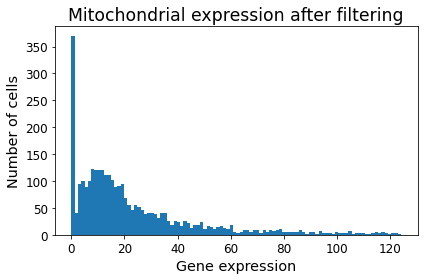

In [6]:
# Plot all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(data_filt, exact_word="TRINITY_DN33980_c0_g1",
                                     library_size_normalize=True,
                                     title="Mitochondrial expression after filtering")

<AxesSubplot:title={'center':'Gene capture before filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

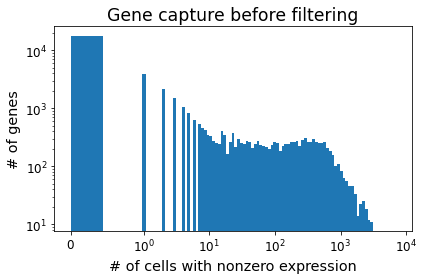

In [7]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [8]:
# ================
# choose a cutoff
cutoff = 20
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=cutoff)
# ================

<AxesSubplot:title={'center':'Gene capture after filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

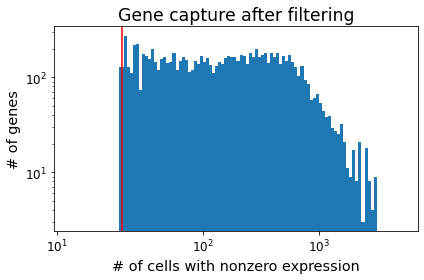

In [9]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), cutoff=20, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

<AxesSubplot:title={'center':'Library size before normalization'}, xlabel='Library size', ylabel='Number of cells'>

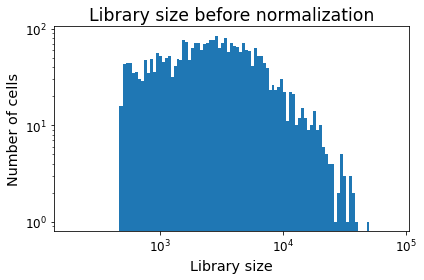

In [10]:
data_filt.shape
scprep.plot.plot_library_size(data_filt, title='Library size before normalization')

In [11]:
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)

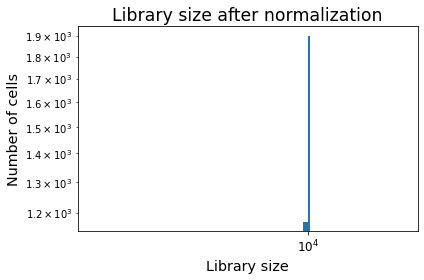

In [12]:
scprep.plot.plot_library_size(data_norm, title='Library size after normalization')
data_filt, metadata['library_size'] = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)

<AxesSubplot:title={'center':'Gene counts before transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

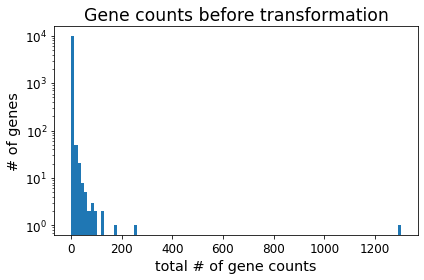

In [13]:
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

<AxesSubplot:title={'center':'Gene counts after transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

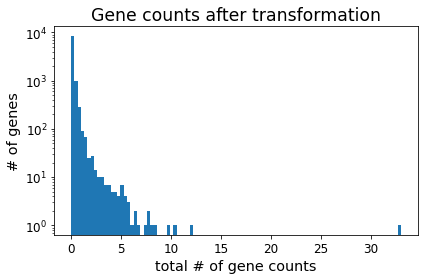

In [14]:
data_sqrt = scprep.transform.sqrt(data_norm)
scprep.plot.histogram(data_sqrt.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

<AxesSubplot:xlabel='Gene mean', ylabel='Standardized variance'>

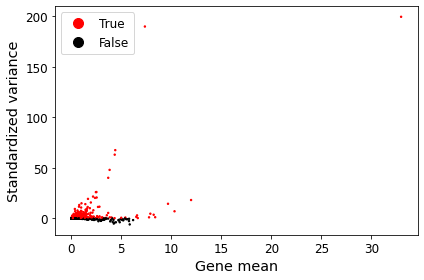

In [15]:
data.to_pickle("data.pickle.gz")
metadata.to_pickle("metadata.pickle.gz")
scprep.plot.plot_gene_variability(data_sqrt, percentile=90)

In [16]:
data_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)
data_hvg.shape

(3072, 1005)

In [17]:
# dimensionality reduction for visualization
data_phate = phate.PHATE(verbose=False).fit_transform(data_hvg)

<AxesSubplot:title={'center':'Podocoryna Whole Body Jellyfish Cells'}, xlabel='PHATE1', ylabel='PHATE2'>

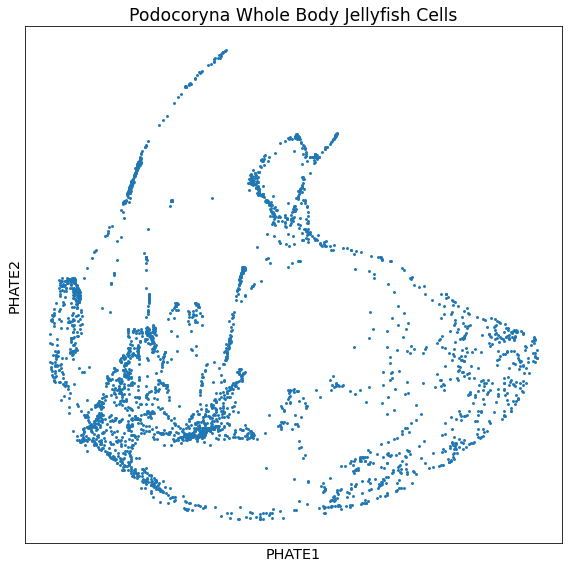

In [18]:
scprep.plot.scatter2d(data_phate, title='Podocoryna Whole Body Jellyfish Cells',
                      ticks=False, label_prefix='PHATE', figsize=(8, 8))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

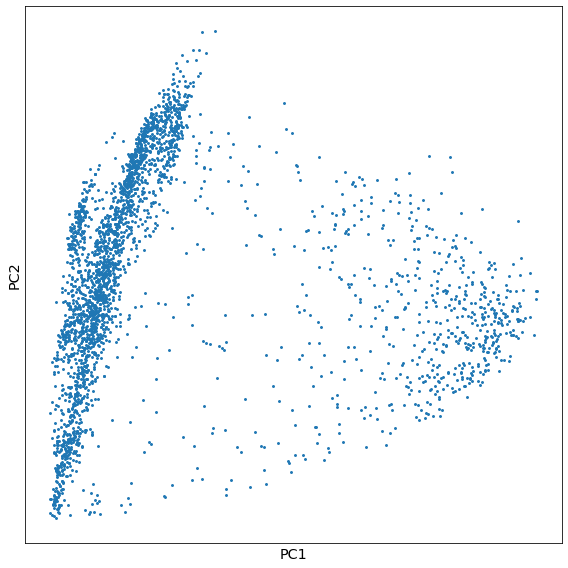

In [19]:
data_pca = scprep.reduce.pca(data_hvg, n_components=100, method='dense')
scprep.plot.scatter2d(data_pca, figsize=(8,8),
                      ticks=False, label_prefix='PC', legend_anchor=(1,1))

/gpfs/ysm/project/dunn/nnp9/conda_envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/gpfs/ysm/project/dunn/nnp9/conda_envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='t-SNE1', ylabel='t-SNE2'>

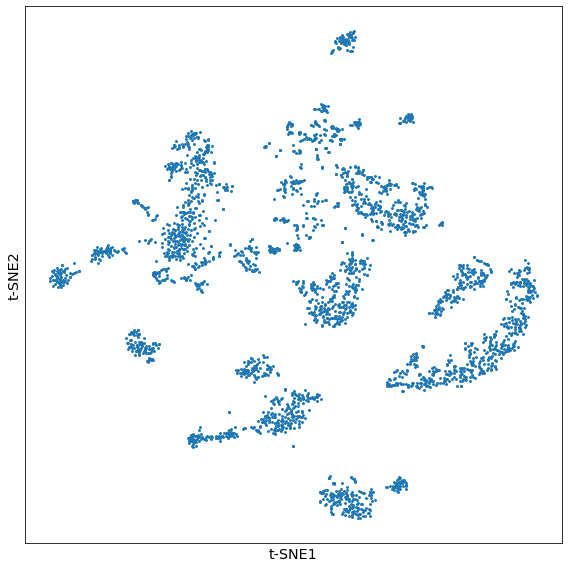

In [20]:
tsne_op = sklearn.manifold.TSNE()
data_tsne = tsne_op.fit_transform(data_pca)
scprep.plot.scatter2d(data_tsne,
                      figsize=(8,8), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE')

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

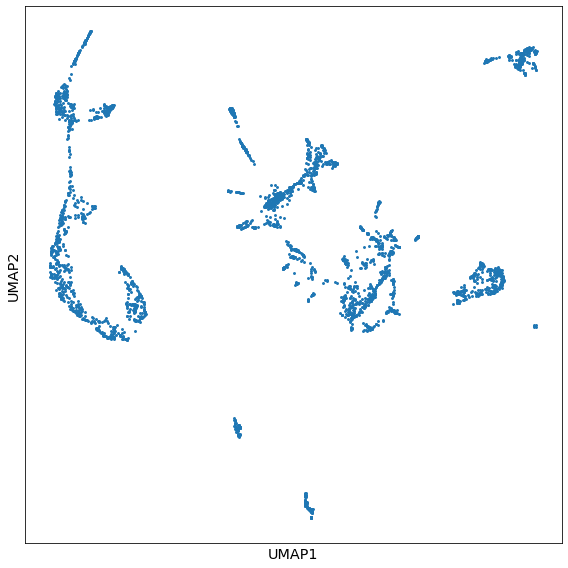

In [21]:
umap_op = umap.UMAP()
data_umap = umap_op.fit_transform(data_pca)
scprep.plot.scatter2d(data_umap,
                      figsize=(8,8), legend_anchor=(1,1), ticks=False, label_prefix='UMAP')

In [22]:
phenograph_clusters, _, _ = phenograph.cluster(data_pca)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 16.064724922180176 seconds
Jaccard graph constructed in 15.797008037567139 seconds
Wrote graph to binary file in 1.6664001941680908 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.908244
Louvain completed 21 runs in 1.8400874137878418 seconds
PhenoGraph complete in 35.81238532066345 seconds


In [24]:
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=12).fit_predict(data_pca)

Calculating KMeans...
Calculated KMeans in 13.86 seconds.


In [25]:
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

In [26]:
with tasklogger.log_task("Louvain"):
    partition = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                       weights="weight", resolution_parameter=1)
    louvain_clusters = np.array(partition.membership)

Calculating Louvain...
Calculated Louvain in 0.24 seconds.


In [27]:
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=12, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating Spectral clustering...
Calculated Spectral clustering in 110.18 seconds.


In [28]:
clusterings = {'Phenograph':phenograph_clusters,
               'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_phate[:,0])
    clusterings[alg] = cl_nu

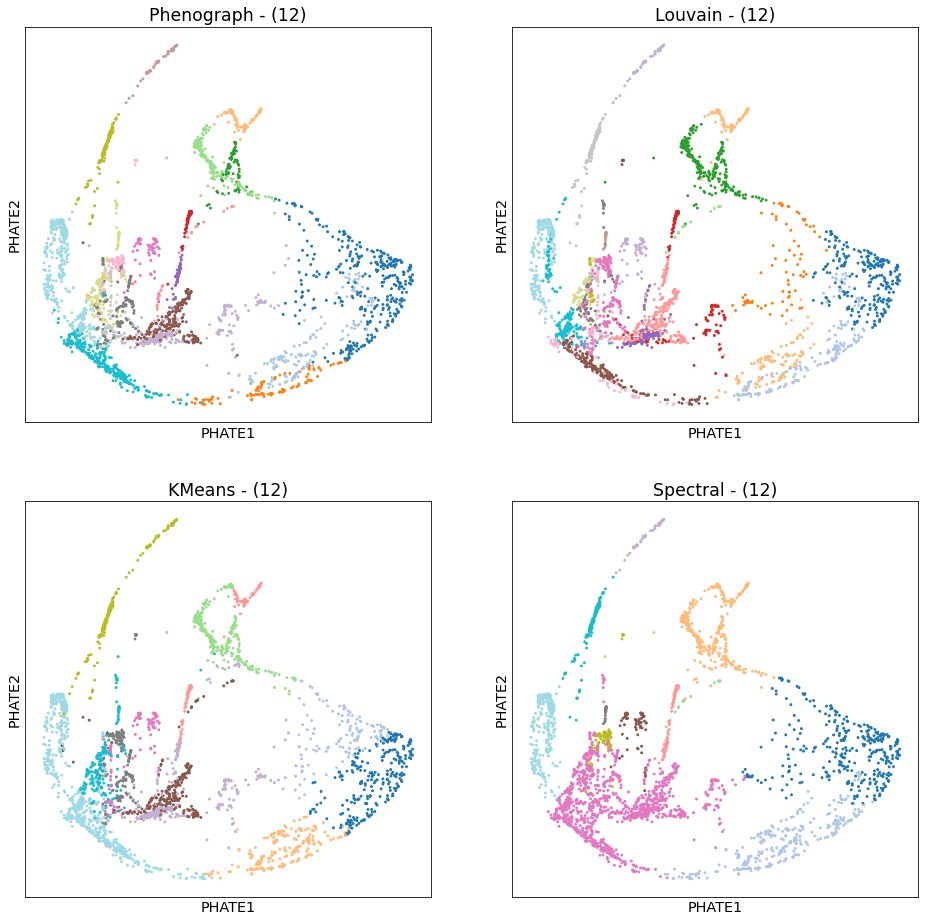

In [29]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algorithm in zip(axes.flatten(), clusterings):
    scprep.plot.scatter2d(data_phate, c=clusterings[algorithm], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algorithm, len(np.unique(clusterings[alg]))), 
                          ticks=False, label_prefix="PHATE", legend=False, discrete=True,
                          ax=ax)

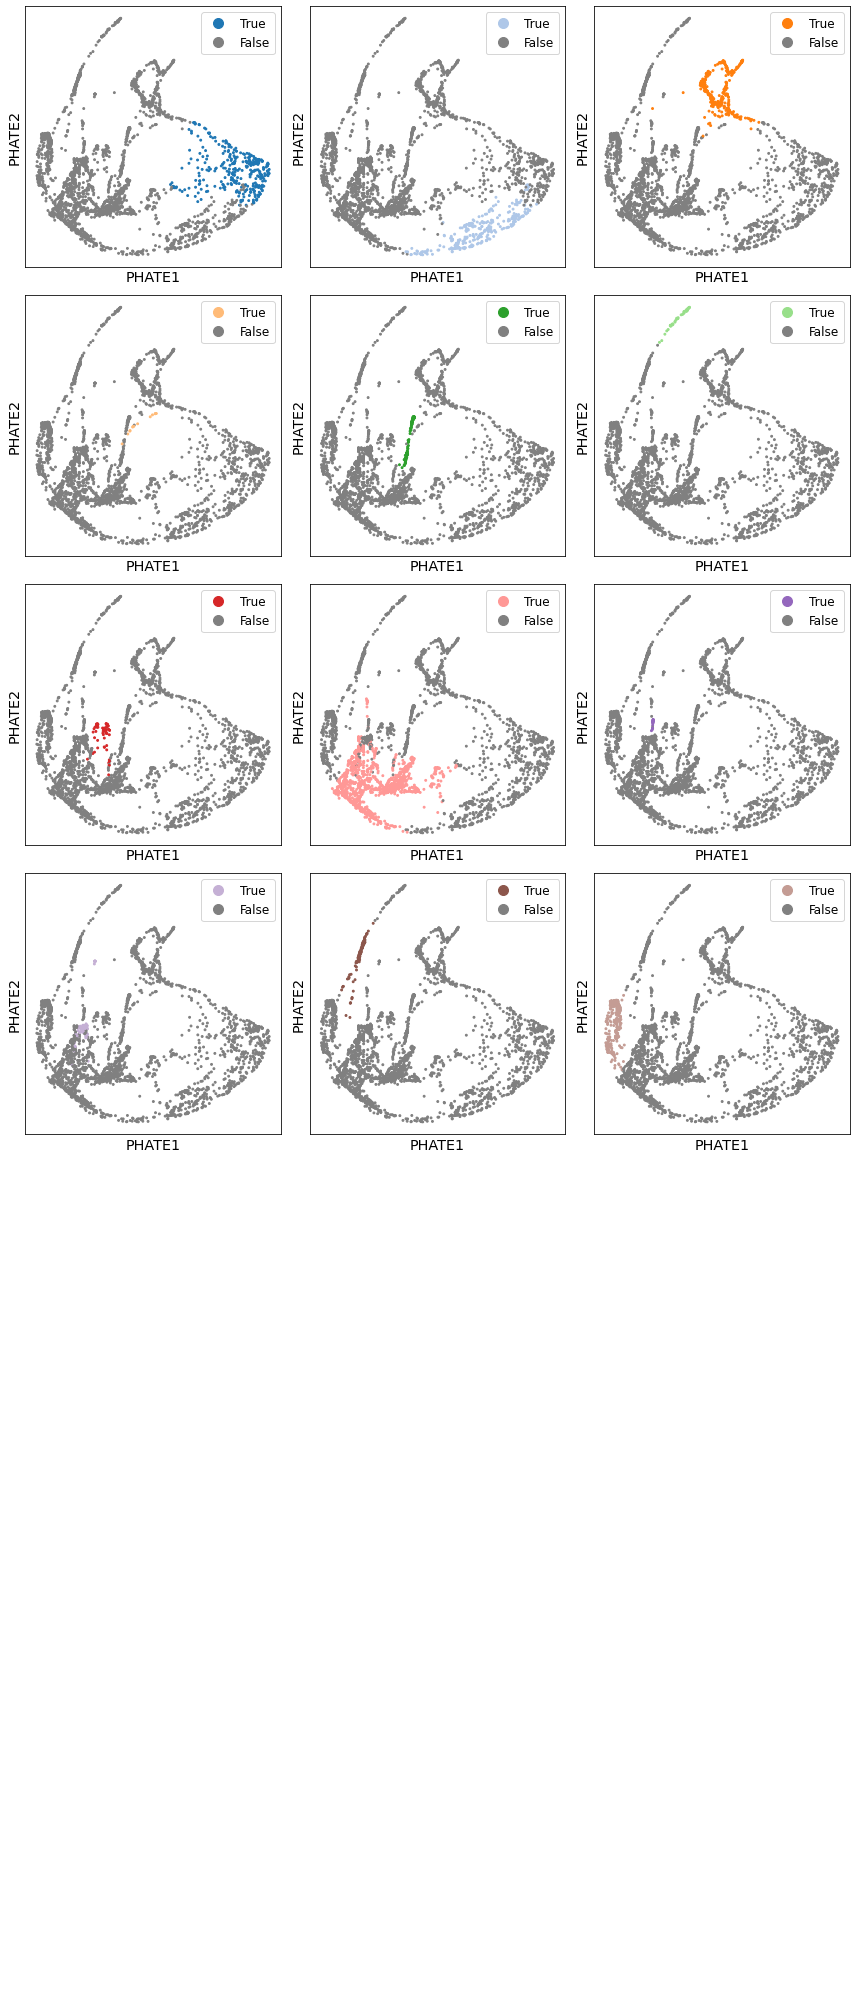

In [30]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()
clusters = clusterings['Spectral']
cluster_ids = np.unique(clusters)
for i in range(len(axes)):
    ax = axes[i]
    try:
        curr_cluster = cluster_ids[i]
        # Returns array([False, True,...,False]) indicating if each cell is in the
        # current cluster
        curr_mask = clusters == curr_cluster  
        scprep.plot.scatter2d(data_phate, c=curr_mask,
                              cmap={True: plt.cm.tab20.colors[i], False: 'grey'},
                              ticks=False, label_prefix='PHATE', ax=ax)
    except IndexError:
        # we have more axes than clusters
        ax.axis('off')


fig.tight_layout()